# A/B experiments

Goal: If recommendations are useful, users will be engaged and spend more time on the website. This will make them more likely to click on REI banner that links to the REI store.

Things to test:
 * Test if the climbing partner recommendation makes users more likely to contact another climbing partner.
 * Test which kind of route recommendation makes users more likely to click on a recommended route.
 * Change in probability of going to REI store.
 
We want to test if $\lambda$ ("click through rate" or "conversion rate") increases.  

In [1]:
%pylab inline

import numpy as np
import scipy.stats as stats
import scipy.special as special

# Plotting
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Frequentist A/B test (p-value)

In [2]:
def estimated_parameters(n, c):
    """Estimate the parameters of the Binomial distribution from experiment.
    For large n, p is approximately a Gaussian random variable.
    
    Parameters
    ----------
    n : Number of trials
    c : Number of conversions
    
    Returns
    -------
    p_hat : Fraction of conversions
    sigma : Uncertainty in p_hat
    """
    p_hat = float(c) / n
    sigma = np.sqrt(p_hat*(1.0-p_hat)/n)
    return p_hat, sigma


def normal_probability_below(xhigh, mu=0.0, sigma=1.0):
    """Area of normal distribution below xhigh.
    """
    # CDF is the area below xhigh
    return stats.norm.cdf(xhigh, loc=mu, scale=sigma)


def normal_probability_above(xlow, mu=0.0, sigma=1.0):
    """Area of normal distribution above xlow
    """
    # CDF is the area below xlow, so 1-CDF is the area above xlow.
    return 1.0 - stats.norm.cdf(xlow, loc=mu, scale=sigma)


def one_sided_p_value(x, mu=0.0, sigma=1.0):
    """Probability of seeing an outcome greater than a distance |x-mu| from mu on one side. 
    """
    # Distance from the mean
    dist = np.abs(x-mu)
    
    # Area of right tail above the mean
    area_right = normal_probability_above(dist, 0.0, sigma)
    
    # Area of both tails that are dist >= |x-mu| from the mean
    return area_right


def two_sided_p_value(x, mu=0.0, sigma=1.0):
    """Probability of seeing an outcome greater than a distance |x-mu| from mu on either side. 
    """
    # Distance from the mean
    dist = np.abs(x-mu)
    
    # Area of right tail above the mean
    area_right = normal_probability_above(dist, 0.0, sigma)
    
    # Area of both tails that are dist >= |x-mu| from the mean
    return 2.0 * area_right


class PValueABTest(object):
    """A/B test using p-value.
    """
    def __init__(self, n_a, c_a, n_b, c_b):
        """
        Parameters
        ----------
        n_a : Number of trials for experiment A
        c_a : Number of conversions for experiment A
        n_b : Number of trials for experiment B
        c_b : Number of conversions for experiment B
        """
        self.n_a = n_a
        self.c_a = c_a
        self.n_b = n_b
        self.c_b = c_b
        
    def z_score(self):
        """Test the null hypothesis that the two distributions are the same (p_A-p_B is zero).
        p_A and p_B are approximately normal distributions with parameters (p_i, sigma_i).
        p_B-p_A has a normal distribution with mean p_B-p_A and standard deviation sqrt(sigma_A^2+sigma_B^2)
        """
        # Estimate parameters for the Gaussians p_A and p_B
        mu_A, sigma_A = estimated_parameters(self.n_a, self.c_a)
        mu_B, sigma_B = estimated_parameters(self.n_b, self.c_b)
        
        # Parameters for the Gaussian p_B-p_A
        mu_BminA = mu_B - mu_A
        sigma_BminA = np.sqrt(sigma_A**2 + sigma_B**2)
        
        # Rescale difference p_B-p_A to unit variance
        # (This is the z-score / effect size)
        z = mu_BminA / sigma_BminA
        return z
    
    def p_value(self, sided=2):
        z = self.z_score()
        if sided==1:
            return one_sided_p_value(z, mu=0.0, sigma=1.0)
        elif sided==2:
            return two_sided_p_value(z, mu=0.0, sigma=1.0)
        else:
            raise ValueError("Sided must be 1 or 2.")

# Bayesian A/B test

In [3]:
class ConversionExperiment(object):
    """Calculate posterior for conversion rate.
    """
    def __init__(self, alpha, beta, n, c):
        """
        Parameters
        alpha, beta : parameters in beta distribution prior
        n : Number of trials
        c : Number of conversions
        """
        self.alpha = alpha
        self.beta = beta
        self.n = n
        self.c = c
        
        self.alpha_post = alpha + c
        self.beta_post = beta + n - c

    def prior(self, lam):
        """Prior belief in conversion rate lambda.
        Beta(alpha, beta) distribution.
        """
        return stats.beta.pdf(lam, self.alpha, self.beta)
        
    def likelihood(self, lam):
        """Likelihood of c conversions out of n trials
        where the conversion rate is lambda.
        This is a binomial distribution if each trial is independent.
        """
        return special.comb(self.n, self.c) * lam**self.c * (1.0-lam)**(self.n-self.c) 
        
    def posterior(self, lam):
        """Posterior for conversion rate lambda.
        """
        return stats.beta.pdf(lam, self.alpha_post, self.beta_post)    
        
    def posterior_rvs(self, size=10000):
        """Random variates sampled from the posterior.
        """
        return stats.beta.rvs(self.alpha_post, self.beta_post, size=size)


class BayesABTest(object):
    """Bayesian A/B test with beta distribution priors.
    """
    def __init__(self, alpha_a, beta_a, n_a, c_a, alpha_b, beta_b, n_b, c_b):
        """Create 2 conversion experiments (A and B).
        """
        self.exp_a = ConversionExperiment(alpha_a, beta_a, n_a, c_a)
        self.exp_b = ConversionExperiment(alpha_b, beta_b, n_b, c_b)

    def posterior_ab(self, lam_a, lam_b):
        """Joint posterior p(lambda_A, lambda_B|d).
        Posteriors for lam_a and lam_b are separable, so just multiply them together.
        """
        post_a = self.exp_a.posterior(lam_a)
        post_b = self.exp_b.posterior(lam_b)
        return post_a * post_b
        
    def posterior_ab_rvs(self, size=10000):
        """Sample from the separable joint posterior p(lambda_A, lambda_B|d).
        """
        post_a = self.exp_a.posterior_rvs(size=size)
        post_b = self.exp_b.posterior_rvs(size=size)
        return np.array([post_a, post_b]).T
    
    def prob_lamb_greater_lama_rec(self, da=0.001, db=0.001):
        """Calculate the probability that lambda_B>lambda_A with rectangle rule.
        (Integral of the joint posterior p(lambda_A, lambda_B|d) in region lambda_B>lambda_A.)
        """
        lam_as = np.arange(0, 1, da)
        lam_bs = np.arange(0, 1, db)
        
        post_as = self.exp_a.posterior(lam_as)
        post_bs = self.exp_b.posterior(lam_bs)
        
        # Integrate with rectangle rule.
        # Posteriors for lam_a and lam_b are separable, 
        # so you can precalculate them, then just multiply them together. 
        post_ab_sum = 0.0
        for a in range(len(lam_as)):
            for b in range(len(lam_bs)):
                post_ab = post_as[a] * post_bs[b]
                if b>=a:
                    post_ab_sum += post_ab
        return post_ab_sum*da*db
    
    def prob_lamb_greater_lama_mc(self, size=10000):
        """Calculate the probability that lambda_B>lambda_A with Monte Carlo integration.
        (Integral of the joint posterior p(lambda_A, lambda_B|d) in region lambda_B>lambda_A.)
        """
        # Draw samples from the joint posterior
        lam_a_samp, lam_b_samp = self.posterior_ab_rvs(size=size).T
        # Integral is the fraction of samples where lambda_b > lambda_a.
        return np.sum(lam_b_samp > lam_a_samp)/float(size)

# Analysis of A/B test

 * Version A has 5000 users. 500 click on the REI banner. (10%)
 * Version B has 1000 users. 125 click on the REI banner. (12.5%)

/Users/lackey/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


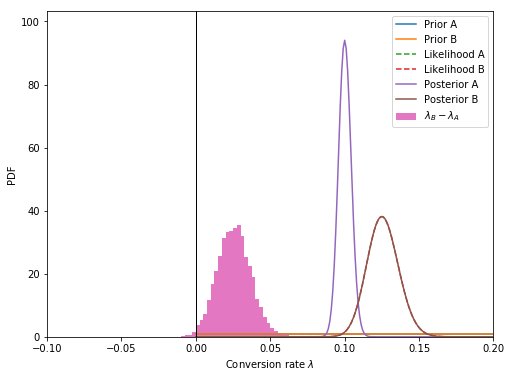

In [28]:
alpha_a, beta_a, n_a, c_a = 1, 1, 5000, 500
alpha_b, beta_b, n_b, c_b = 1, 1, 1000, 125

exp_a = ConversionExperiment(alpha_a, beta_a, n_a, c_a)
exp_b = ConversionExperiment(alpha_b, beta_b, n_b, c_b)

lam = np.linspace(0, 1, 1001)

prior_a = exp_a.prior(lam)
prior_b = exp_b.prior(lam)

like_a = n_a * exp_a.likelihood(lam)
like_b = n_b * exp_b.likelihood(lam)

post_a = exp_a.posterior(lam)
post_b = exp_b.posterior(lam)

post_a_samp = exp_a.posterior_rvs(size=10000)
post_b_samp = exp_b.posterior_rvs(size=10000)


fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(lam, prior_a, label='Prior A')
ax.plot(lam, prior_b, label='Prior B')
ax.plot(lam, like_a, ls='--', label='Likelihood A')
ax.plot(lam, like_b, ls='--', label='Likelihood B')

ax.plot(lam, post_a, label='Posterior A')
ax.plot(lam, post_b, label='Posterior B')

ax.hist(post_b_samp-post_a_samp, bins=np.linspace(-0.5, 1, 601), density=True, label=r'$\lambda_B-\lambda_A$')
ax.axvline(0, c='k', lw=1)

ax.set_xlim(-0.1, 0.2)
ax.set_ylim(0.0, 1.1*np.max(post_a))
ax.set_xlabel(r'Conversion rate $\lambda$')
ax.set_ylabel(r'PDF')
ax.legend()

## Bayesian A/B test
Calculate probability that click-through-rate for experiment B ($\lambda_B$) is greater than for experiment A ($\lambda_A$).

In [29]:
# Probability that version B of page leads to more conversions than version A
bayes_ab = BayesABTest(alpha_a, beta_a, n_a, c_a, alpha_b, beta_b, n_b, c_b)
print bayes_ab.prob_lamb_greater_lama_rec(da=0.0001, db=0.0001)
print bayes_ab.prob_lamb_greater_lama_mc(size=10**7)

0.9906717867932141
0.9904827


## Sanity check with p-value
Probability of seeing results this extreme assuming the null hypothesis that versions A and B have the same click-through-rates.

In [30]:
pvalue_ab = PValueABTest(n_a, c_a, n_b, c_b)
print pvalue_ab.z_score()
print pvalue_ab.p_value(sided=1)
print pvalue_ab.p_value(sided=2)

2.215123324886302
0.013375800430530771
0.026751600861061542


# Increase in revenue per visit to mountainproject.com

In [31]:
def revenue_per_visit(lam, frac_buy=0.1, mean_sale=100.0):
    """Estimate expected revenue at REI per visit to mountainproject.com.
    
    Parameters
    ----------
    lam : Conversion / click-through rate
    frac_buy : Fraction of customers on REI page who make purchase.
    mean_sale : Average revenue for customer who does make purchase.
    """
    return lam * frac_buy * mean_sale

In [32]:
# Draw samples from the joint posterior
size = 10000
lam_a_samp, lam_b_samp = bayes_ab.posterior_ab_rvs(size=size).T

revenue_a = revenue_per_visit(lam_a_samp)
revenue_b = revenue_per_visit(lam_b_samp)

delta_revenue = revenue_b - revenue_a

(-0.2, 2.0)

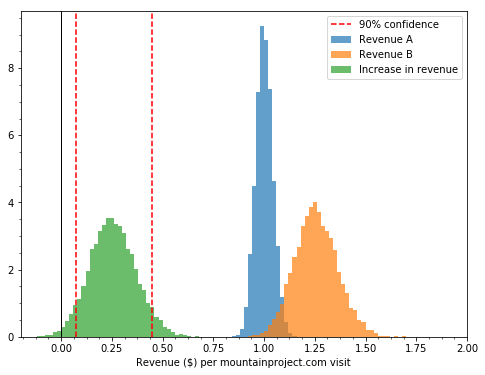

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(revenue_a, bins=np.linspace(0, 2, 101), density=True, alpha=0.7, label='Revenue A')
ax.hist(revenue_b, bins=np.linspace(0, 2, 101), density=True, alpha=0.7, label='Revenue B')
ax.hist(delta_revenue, bins=np.linspace(-1, 1, 101), density=True, alpha=0.7, label='Increase in revenue')

ax.axvline(np.percentile(delta_revenue, 5), c='r', ls='--', label='90% confidence')
ax.axvline(np.percentile(delta_revenue, 95), c='r', ls='--')

ax.axvline(0, c='k', lw=1)
ax.legend()
ax.set_xlabel('Revenue ($) per mountainproject.com visit')
ax.minorticks_on()
ax.set_xlim(-0.2, 2.0)